<a href="https://colab.research.google.com/github/harperd17/energy_volatility_prediction/blob/main/notebooks/EDA/weather_data_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The goal of this notebook is to see which areas have the highest correlations to the target COV and whether other variables influence how correlated the weather variables are. Ex. is weather more influential for our target variable in areas with higher solar?

In [ ]:
!pip install plotly==4.5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
!pip install us
import us
import seaborn as sns

     |████████████████████████████████| 7.1 MB 7.5 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 132 kB 7.5 MB/s 
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11942 sha256=daa5d5570891387616fa9965c421c0aa4a6d8d264fa2ce738163a6a751765882
  Stored in directory: /root/.cache/pip/wheels/ca/6b/11/cda9ea2438f721330a35c9a2c8e34b4aedcd34c89af48a4d00
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp37-cp37m-linux_x86_64.whl size=72187 sha256=cc95d331cb8fb5a119eda6e28142f5471291b9216710df1477cd62dcd45564fa
  Stored in directory: /root/.cache/pip/wheels/a1/99/51/7de469e37cd1b3c763c24394e1ebf1baa2d79e094bf346cf80
Successfully built us jellyfish


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/Shareddrives/Data606_Energy/data/weather

/content/drive/Shareddrives/Data606_Energy/data/weather


In [ ]:
temp_summary = pd.read_csv('temp_data_by_location.csv')
drought_summary = pd.read_csv('drought_data_by_location.csv')

In [ ]:
all_data_state = pd.read_csv('../merge_ready/annual_weather_final.csv')

In [ ]:
target_COV = pd.read_csv('../merge_ready/merged_data_2001-2020.csv')[['target_COV','Year','State']]

In [ ]:
merged_data = pd.read_csv('../merge_ready/merged_data_2001-2020.csv')
vars_to_not_use = list(pd.read_csv('/content/drive/Shareddrives/Data606_Energy/data/merge_ready/annual_powerplant_netgeneration_2001_2021.csv').columns[2:])
vars_to_not_use += ['Agg_total_plant_MWh_y','Agg_total_plant_count_y','year.1']

for col in vars_to_not_use:
  try:
    del merged_data[col]
  except Exception as e:
    print(e)

'Agg_total_plant_MWh'
'Agg_total_plant_count'


In [ ]:
temp_summary['coord'] = list(zip(temp_summary['x'],temp_summary['y']))
drought_summary['coord'] = list(zip(drought_summary['x'],drought_summary['y']))

In [ ]:
pdsi_data = drought_summary.copy()[['Standardized Drought '+str(i) for i in range(1,13)]+['State','Year','x','y','Population Density']]
temp_data = temp_summary.copy()[['Standardized Temp '+str(i) for i in range(1,13)]+['State','Year','x','y','Population Density']]

### Create Functions to Process the Dataframes

In [ ]:
# this function takes in a dataframe and converts it into an applicable format using the function format_df
# and then subsets the rows based on the input month. Then, this is merged with a dataframe which has the target variable
# the variable "variable_name" is used for assigning the name of the value - usually temp or pdsi
def get_month_corr_data(df, month, target_df):
  new_month_data_target = pd.merge(df[[month,'Year','State','x','y']],target_df[['State','Year','target_COV']],on=['State','Year'])
  # get a column that is the coordinate pair
  new_month_data_target['coord'] = [(new_month_data_target['x'].iloc[i], new_month_data_target['y'].iloc[i]) for i in range(new_month_data_target.shape[0])]
  # find the unique locations and loop through them to get correlations
  unique_locations = new_month_data_target['coord'].unique()
  correlations = []
  states = []
  for location in unique_locations:
    df_subset = new_month_data_target.copy()[new_month_data_target['coord']==location]
    correlations.append(np.array(df_subset[[month,'target_COV']].corr())[0][1])
    states.append(df_subset['State'].iloc[0])
  array_locations = np.array([np.array(c) for c in unique_locations])

  # make a dataframe out of the correlations
  corr_df = pd.DataFrame({'x':array_locations[:,0],'y':array_locations[:,1],'Correlation':correlations,'State':states})
  return corr_df

## Abs
### Make versions of the temp and pdsi dataframes that are only the absolute value of the standardized values

In [ ]:
pdsi_data_abs = pdsi_data.copy()
for col in pdsi_data_abs.columns:
  try:
    pdsi_data_abs[col] = pdsi_data_abs[col].abs()
  except:
    ...


temp_data_abs = temp_data.copy()
for col in temp_data_abs.columns:
  try:
    temp_data_abs[col] = temp_data_abs[col].abs()
  except:
    ...

# Above/Below
### Make temp and pdsi dataframe masks that show which months where the standardized values are either positive or negative.

In [ ]:
pdsi_data_above = pdsi_data.copy()
pdsi_data_below = pdsi_data.copy()
for col in pdsi_data.columns:
  if col not in ['State','Year','x','y','Population Density']:
    try:
      #col.year
      pdsi_data_above[col][(pdsi_data_above[col] < 0)] = np.nan
      pdsi_data_below[col][(pdsi_data_below[col] > 0)] = np.nan
    except:
      ...

temp_data_above = temp_data.copy()
temp_data_below = temp_data.copy()
for col in temp_data.columns:
  if col not in ['State','Year','x','y','Population Density']:
    try:
      #col.year
      temp_data_above[col][(temp_data_above[col] < 0)] = np.nan
      temp_data_below[col][(temp_data_below[col] > 0)] = np.nan
    except:
      ...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning

# Find the correlations between each locations values and the target COV
### Do this with each of the dataframes above 
1. See if absolute value of the standardized variable is correlated - maybe any weather pattersn away from average are important.
2. See if locations and months with above average weather are more correlated with the target COV
3. See if locations and months with below average weather are more correlated with the target COV
4. See if the regular standardized values are correlated with the target COV

In [ ]:
# this took quite a while to run so I am commenting it out since the results have been saved
#for month in range(1,13):
  # print(month)
  # corr_df_pdsi = get_month_corr_data(pdsi_data,'Standardized Drought '+str(month),target_COV)
  # corr_df_pdsi_abs = get_month_corr_data(pdsi_data_abs.copy(),'Standardized Drought '+str(month),target_COV)
  # corr_df_pdsi_above = get_month_corr_data(pdsi_data_above.copy(),'Standardized Drought '+str(month),target_COV)
  # corr_df_pdsi_below = get_month_corr_data(pdsi_data_below.copy(),'Standardized Drought '+str(month),target_COV)
  # corr_df_pdsi.to_csv('for_correlations/PDSI Correlations {}.csv'.format(month))
  # corr_df_pdsi_abs.to_csv('for_correlations/PDSI Abs Correlations {}.csv'.format(month))
  # corr_df_pdsi_above.to_csv('for_correlations/PDSI Above Correlations {}.csv'.format(month))
  # corr_df_pdsi_below.to_csv('for_correlations/PDSI Below Correlations {}.csv'.format(month))
  # # save the results
  # corr_df_temp = get_month_corr_data(temp_data,'Standardized Temp '+str(month),target_COV)
  # corr_df_temp_abs = get_month_corr_data(temp_data_abs.copy(),'Standardized Temp '+str(month),target_COV)
  # corr_df_temp_above = get_month_corr_data(temp_data_above.copy(),'Standardized Temp '+str(month),target_COV)
  # corr_df_temp_below = get_month_corr_data(temp_data_below.copy(),'Standardized Temp '+str(month),target_COV)
  # corr_df_temp.to_csv('for_correlations/Temp Correlations {}.csv'.format(month))
  # corr_df_temp_abs.to_csv('for_correlations/Temp Abs Correlations {}.csv'.format(month))
  # corr_df_temp_above.to_csv('for_correlations/Temp Above Correlations {}.csv'.format(month))
  # corr_df_temp_below.to_csv('for_correlations/Temp Below Correlations {}.csv'.format(month))

In [ ]:
# get the mean absolute value of correlations for each month and for each type of underlying correlation
abs_temp_corrs = [pd.read_csv('for_correlations/Temp Abs Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]
abs_pdsi_corrs = [pd.read_csv('for_correlations/PDSI Abs Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]
above_temp_corrs = [pd.read_csv('for_correlations/Temp Above Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]
above_pdsi_corrs = [pd.read_csv('for_correlations/PDSI Above Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]
below_temp_corrs = [pd.read_csv('for_correlations/Temp Below Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]
below_pdsi_corrs = [pd.read_csv('for_correlations/PDSI Below Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]
temp_corrs = [pd.read_csv('for_correlations/Temp Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]
pdsi_corrs = [pd.read_csv('for_correlations/PDSI Correlations {}.csv'.format(month))['Correlation'].abs().mean() for month in range(1,13)]

In [ ]:
# load the dataframes into lists - one dataframe per month and per uynderlying correlation type
abs_temp_corr_dfs = [pd.read_csv('for_correlations/Temp Abs Correlations {}.csv'.format(month)) for month in range(1,13)]
abs_pdsi_corr_dfs = [pd.read_csv('for_correlations/PDSI Abs Correlations {}.csv'.format(month)) for month in range(1,13)]
above_temp_corr_dfs = [pd.read_csv('for_correlations/Temp Above Correlations {}.csv'.format(month)) for month in range(1,13)]
above_pdsi_corr_dfs = [pd.read_csv('for_correlations/PDSI Above Correlations {}.csv'.format(month)) for month in range(1,13)]
below_temp_corr_dfs = [pd.read_csv('for_correlations/Temp Below Correlations {}.csv'.format(month)) for month in range(1,13)]
below_pdsi_corr_dfs = [pd.read_csv('for_correlations/PDSI Below Correlations {}.csv'.format(month)) for month in range(1,13)]
temp_corr_dfs = [pd.read_csv('for_correlations/Temp Correlations {}.csv'.format(month)) for month in range(1,13)]
pdsi_corr_dfs = [pd.read_csv('for_correlations/PDSI Correlations {}.csv'.format(month)) for month in range(1,13)]

# Some Correlation Plots

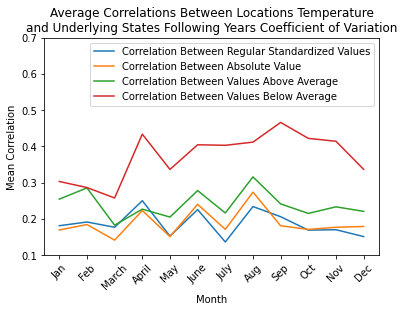

In [ ]:
# find which month and data type offers the highest average absolute value of correlation
plt.plot(range(1,13),temp_corrs,label='Correlation Between Regular Standardized Values')
plt.plot(range(1,13),abs_temp_corrs,label='Correlation Between Absolute Value')
plt.plot(range(1,13),above_temp_corrs,label='Correlation Between Values Above Average')
plt.plot(range(1,13),below_temp_corrs,label='Correlation Between Values Below Average')
plt.legend()
plt.title('Average Correlations Between Locations Temperature\nand Underlying States Following Years Coefficient of Variation')
plt.xlabel('Month')
plt.ylabel('Mean Correlation')
plt.ylim([0.1,0.7])
plt.xticks(range(1,13),['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec'],rotation=45);

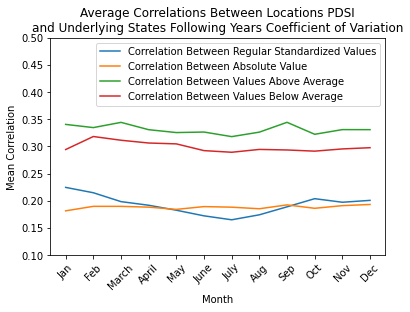

In [ ]:
# find which month and data type offers the highest average absolute value of correlation
plt.plot(range(1,13),pdsi_corrs,label='Correlation Between Regular Standardized Values')
plt.plot(range(1,13),abs_pdsi_corrs,label='Correlation Between Absolute Value')
plt.plot(range(1,13),above_pdsi_corrs,label='Correlation Between Values Above Average')
plt.plot(range(1,13),below_pdsi_corrs,label='Correlation Between Values Below Average')
plt.legend()
plt.title('Average Correlations Between Locations PDSI\nand Underlying States Following Years Coefficient of Variation')
plt.xlabel('Month')
plt.ylabel('Mean Correlation')
plt.ylim([0.1,0.5])
plt.xticks(range(1,13),['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec'],rotation=45);

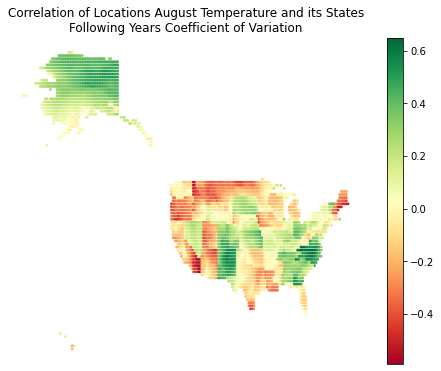

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(temp_corr_dfs[7]['x'],temp_corr_dfs[7]['y'],c=temp_corr_dfs[7]['Correlation'],cmap='RdYlGn',s=3)
plt.title('Correlation of Locations August Temperature and its States\nFollowing Years Coefficient of Variation')
plt.axis('off')
plt.colorbar();

These correlations look very state specific. For example, places like Florida have negative correlations between their standardized temperatures and the coefficient of variation. This implies that when temperature is below average, the more below average it is, the less variability there is in electricity prices. However, if you go up to southern Georgia, there is a positive correlation meaning that the further below from average the temperature is, the more variability there is in electricity prices.

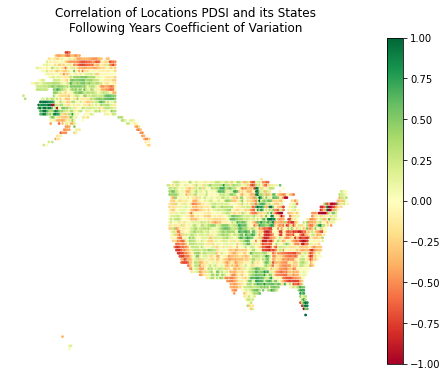

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(below_pdsi_corr_dfs[9]['x'],below_pdsi_corr_dfs[9]['y'],c=below_pdsi_corr_dfs[9]['Correlation'],cmap='RdYlGn',s=3)
plt.title('Correlation of Locations PDSI and its States\nFollowing Years Coefficient of Variation')
plt.axis('off')
plt.colorbar();

This plot seems to make some more sense. It shows areas like the southwest having a negative correlation between PDSI and electricitiy price variability. Since a lower PDSI means worse drought, this makes sense because it suggests droughts in the southwest create more price variability. This also happens alot in some areas of the pacific northwest which seem like they might have a decent ammount of hydroelectric.

## See how this stuff correlates with population density - do areas with higher population density tend to have higher degrees of correlation with that states price volatility?

In [ ]:
temp_corr_pop_corr = pd.merge(above_temp_corr_dfs[7].copy(),temp_data.copy(),on=['x','y'],how='outer')
temp_corr_pop_corr['Correlation'] = temp_corr_pop_corr['Correlation'].abs()
print('Temperature Correlations between degree of correlation and population measures')
temp_corr_pop_corr[['Correlation','Population Density']].corr()

Temperature Correlations between degree of correlation and population measures


,Correlation,Population Density
Correlation,1.0000,-0.0352
Population Density,-0.0352,1.0000


In [ ]:
pdsi_corr_pop_corr = pd.merge(below_pdsi_corr_dfs[9].copy(),pdsi_data.copy(),on=['x','y'],how='outer')
pdsi_corr_pop_corr['Correlation'] = pdsi_corr_pop_corr['Correlation'].abs()
print('PDSI Correlations between degree of correlation and population measures')
pdsi_corr_pop_corr[['Correlation','Population Density']].corr()

PDSI Correlations between degree of correlation and population measures


,Correlation,Population Density
Correlation,1.000000,0.057148
Population Density,0.057148,1.000000


There is a slight correlation between the log population density and the correlation with the PDSI data, but not a very large ammount. For temperature, there isn't any correlation.

# Explore if these correlations relate to other variables - do other variables impact how much weather impacts the prices?

In [ ]:
# this function takes in a dataframe of the correlations and then groups it by state, getting the mean correlation
def find_correlations(correlations_df, merged_data_state):
  corrs_by_state = correlations_df.groupby(by='State').mean()
  merged_data_all = pd.merge(merged_data_state,corrs_by_state,on='State')
  pos_corrs = merged_data_all.copy()[merged_data_all['Correlation']>=0]
  neg_corrs = merged_data_all.copy()[merged_data_all['Correlation']<0]
  all_corrs = merged_data_all.copy()
  top_pos_corrs = list(pos_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6])
  top_pos_corrs_names = list(pos_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6].index)
  top_neg_corrs = list(neg_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6])
  top_neg_corrs_names = list(neg_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6].index)
  top_corrs = list(all_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6])
  top_corrs_names = list(all_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6].index)
  return (top_pos_corrs, top_neg_corrs, top_pos_corrs_names, top_neg_corrs_names, top_corrs, top_corrs_names)

In [ ]:
# get measures of % of different fuel types by state
mean_by_state = merged_data.groupby(by='State').mean()
mean_by_state['Added'] = (mean_by_state['Agg_R_Wind_MWh'] + mean_by_state['Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh'] + mean_by_state['Agg_R_Solar_MWh'] +
                          mean_by_state['Agg_R_Other_MWh'] + mean_by_state['Agg_R_Oil_Gas_MWh'] + mean_by_state['Agg_R_Nuclear_MWh'] + mean_by_state['Agg_R_Natural_Gas_MWh'] +
                          mean_by_state['Agg_R_Municipal_Waste_MWh'] + mean_by_state['Agg_R_Hydroelectric_MWh'] + mean_by_state['Agg_R_Geothermal_MWh'] + mean_by_state['Agg_R_Coal_MWh'] +
                          mean_by_state['Agg_R_Biomass_MWh'])

mean_by_state['Percent Coal'] = mean_by_state['Agg_R_Coal_MWh']/mean_by_state['Added']
mean_by_state['Percent Wind'] = mean_by_state['Agg_R_Wind_MWh']/mean_by_state['Added']
mean_by_state['Percent Batteries'] = mean_by_state['Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh']/mean_by_state['Added']
mean_by_state['Percent Solar'] = mean_by_state['Agg_R_Solar_MWh']/mean_by_state['Added']
mean_by_state['Percent Other'] = mean_by_state['Agg_R_Other_MWh']/mean_by_state['Added']
mean_by_state['Percent Oil Gas'] = mean_by_state['Agg_R_Oil_Gas_MWh']/mean_by_state['Added']
mean_by_state['Percent Nuclear'] = mean_by_state['Agg_R_Nuclear_MWh']/mean_by_state['Added']
mean_by_state['Percent Natural Gas'] = mean_by_state['Agg_R_Natural_Gas_MWh']/mean_by_state['Added']
mean_by_state['Percent Municipal Waste'] = mean_by_state['Agg_R_Municipal_Waste_MWh']/mean_by_state['Added']
mean_by_state['Percent Hydroelectric'] = mean_by_state['Agg_R_Hydroelectric_MWh']/mean_by_state['Added']
mean_by_state['Percent Geothermal'] = mean_by_state['Agg_R_Geothermal_MWh']/mean_by_state['Added']
mean_by_state['Percent Biomass'] = mean_by_state['Agg_R_Biomass_MWh']/mean_by_state['Added']

In [ ]:
mean_by_state.head()

,Year,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Hot Summer Months,Cold Winter Months,Dry Summer Months,COV,target_COV,COM_percapita_mean_kWh_electricacc,RES_percapita_mean_kWh_electricacc,COM_percapita_mean_kWh_statepop,RES_percapita_mean_kWh_statepop,Agg_total_plant_MWh_x,Agg_total_plant_count_x,Agg_R_Biomass_MWh,Agg_R_Biomass_count,Agg_R_Coal_MWh,Agg_R_Coal_count,Agg_R_Geothermal_MWh,Agg_R_Geothermal_count,Agg_R_Hydroelectric_MWh,Agg_R_Hydroelectric_count,Agg_R_Municipal_Waste_MWh,Agg_R_Municipal_Waste_count,Agg_R_Natural_Gas_MWh,Agg_R_Natural_Gas_count,Agg_R_Nuclear_MWh,Agg_R_Nuclear_count,Agg_R_Oil_Gas_MWh,Agg_R_Oil_Gas_count,Agg_R_Other_MWh,Agg_R_Other_count,Agg_R_Solar_MWh,Agg_R_Solar_count,Agg_R_Wind_MWh,Agg_R_Wind_count,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh,Agg_R_batteries_or_other_use_of_electricity_as_an_energy_source_count,Added,Percent Coal,Percent Wind,Percent Batteries,Percent Solar,Percent Other,Percent Oil Gas,Percent Nuclear,Percent Natural Gas,Percent Municipal Waste,Percent Hydroelectric,Percent Geothermal,Percent Biomass
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,2010.5,3.9,4.15,5.3,6.45,5.3,6.45,5.05,6.45,0.90,3.4,3.85,0.029065,0.028781,0.23005,0.0326,0.45725,0.32490,6.142794e+06,1650.75,0.0042,0.00710,0.10615,0.04385,0.0000,0.00000,0.21810,0.18595,0.00000,0.00000,0.50810,0.08585,0.00000,0.00000,0.15475,0.65390,0.00000,0.00000,0.00000,0.00000,0.00885,0.01685,-0.00015,0.00655,1.00000,0.106150,0.008850,-0.00015,0.000000,0.00000,0.154750,0.000000,0.508100,0.00000,0.218100,0.00000,0.004200
AL,2010.5,3.9,4.15,5.3,6.45,5.3,6.45,5.05,6.45,1.15,3.0,3.25,0.051321,0.051500,0.01465,0.0036,0.25260,0.36225,1.306578e+08,1424.90,0.0213,0.17055,0.34865,0.10335,0.0000,0.00000,0.06960,0.18150,0.00000,0.00000,0.27010,0.28195,0.28820,0.01750,0.00145,0.23130,0.00060,0.00615,0.00045,0.00700,0.00000,0.00000,0.00000,0.00080,1.00035,0.348528,0.000000,0.00000,0.000450,0.00060,0.001449,0.288099,0.270005,0.00000,0.069576,0.00000,0.021293
AR,2010.5,3.9,4.15,5.3,6.45,5.3,6.45,5.05,6.45,1.15,3.3,3.30,0.059043,0.065918,0.10635,0.0220,0.24985,0.38065,5.595958e+07,870.10,0.0257,0.14760,0.45865,0.06890,0.0000,0.00000,0.05475,0.23395,0.00000,0.00000,0.19695,0.25575,0.26005,0.01445,0.00320,0.25245,0.00025,0.00925,0.00050,0.01480,0.00000,0.00000,0.00000,0.00300,1.00005,0.458627,0.000000,0.00000,0.000500,0.00025,0.003200,0.260037,0.196940,0.00000,0.054747,0.00000,0.025699
AZ,2010.5,3.9,4.15,5.3,6.45,5.3,6.45,5.05,6.45,1.85,2.9,3.90,0.080672,0.079322,0.09300,0.0132,0.38640,0.44045,9.123567e+07,1122.05,0.0011,0.02575,0.24305,0.07355,0.0000,0.00000,0.07705,0.12685,0.00000,0.00000,0.32605,0.31325,0.33345,0.01225,0.00025,0.21435,0.00000,0.00245,0.01640,0.20770,0.00245,0.01925,0.00000,0.00480,0.99980,0.243099,0.002450,0.00000,0.016403,0.00000,0.000250,0.333517,0.326115,0.00000,0.077065,0.00000,0.001100
CA,2010.5,3.9,4.15,5.3,6.45,5.3,6.45,5.05,6.45,1.10,3.1,3.75,0.086722,0.082225,0.12100,0.0122,0.45710,0.34395,1.749394e+08,10474.30,0.0285,0.08070,0.00365,0.00460,0.0682,0.03525,0.17330,0.29975,0.00135,0.00265,0.53205,0.29750,0.10155,0.00140,0.01070,0.06040,0.00235,0.00815,0.03940,0.13115,0.03880,0.07425,0.00000,0.00430,0.99985,0.003651,0.038806,0.00000,0.039406,0.00235,0.010702,0.101565,0.532130,0.00135,0.173326,0.06821,0.028504


In [ ]:
to_remove = ['COV','target_COV','Added','Hot Summer Months','Cold Winter Months','Dry Summer Months']
for col in mean_by_state.columns:
  if '=F' in col:
    to_remove.append(col)
for col in to_remove:
  del mean_by_state[col]

for col in mean_by_state.columns:
  if 'Agg' in col and 'Agg_total_plant' not in col:
    del mean_by_state[col]

Go through each of the types of weather standardized variables - only those greater than 0, only those less than 0, the absolute value of all of them, or the regular standardized numbers.

In [ ]:
total_in_each = 5

all_top_temp_positives = []
all_top_temp_negatives = []
all_top_temp = []
all_top_pdsi_positives = []
all_top_pdsi_negatives = []
all_top_pdsi = []

all_top_temp_positives_names = []
all_top_temp_negatives_names = []
all_top_temp_names = []
all_top_pdsi_positives_names = []
all_top_pdsi_negatives_names = []
all_top_pdsi_names = []

months = []
types = []

for month in range(12):
  pos, neg, pos_names, neg_names, all, all_names = find_correlations(abs_temp_corr_dfs[month],mean_by_state)
  all_top_temp_positives += pos
  all_top_temp_negatives += neg
  all_top_temp_positives_names += pos_names
  all_top_temp_negatives_names += neg_names

  all_top_temp += all
  all_top_temp_names += all_names


  pos, neg, pos_names, neg_names, all, all_names = find_correlations(abs_pdsi_corr_dfs[month],mean_by_state)
  all_top_pdsi_positives += pos
  all_top_pdsi_negatives += neg
  all_top_pdsi_positives_names += pos_names
  all_top_pdsi_negatives_names += neg_names
  
  all_top_pdsi += all
  all_top_pdsi_names += all_names

  
  months += [month+1]*total_in_each
  types += ['Abs']*total_in_each

  pos, neg, pos_names, neg_names, all, all_names = find_correlations(above_temp_corr_dfs[month],mean_by_state)
  all_top_temp_positives += pos
  all_top_temp_negatives += neg
  all_top_temp_positives_names += pos_names
  all_top_temp_negatives_names += neg_names

  all_top_temp += all
  all_top_temp_names += all_names



  pos, neg, pos_names, neg_names, all, all_names = find_correlations(above_pdsi_corr_dfs[month],mean_by_state)
  all_top_pdsi_positives += pos
  all_top_pdsi_negatives += neg
  all_top_pdsi_positives_names += pos_names
  all_top_pdsi_negatives_names += neg_names

  all_top_pdsi += all
  all_top_pdsi_names += all_names


  months += [month+1]*total_in_each
  types += ['Above']*total_in_each


  pos, neg, pos_names, neg_names, all, all_names = find_correlations(below_temp_corr_dfs[month],mean_by_state)
  all_top_temp_positives += pos
  all_top_temp_negatives += neg
  all_top_temp_positives_names += pos_names
  all_top_temp_negatives_names += neg_names

  all_top_temp += all
  all_top_temp_names += all_names



  pos, neg, pos_names, neg_names, all, all_names = find_correlations(below_pdsi_corr_dfs[month],mean_by_state)
  all_top_pdsi_positives += pos
  all_top_pdsi_negatives += neg
  all_top_pdsi_positives_names += pos_names
  all_top_pdsi_negatives_names += neg_names

  all_top_pdsi += all
  all_top_pdsi_names += all_names


  months += [month+1]*total_in_each
  types += ['Below']*total_in_each


  pos, neg, pos_names, neg_names, all, all_names = find_correlations(temp_corr_dfs[month],mean_by_state)
  all_top_temp_positives += pos
  all_top_temp_negatives += neg
  all_top_temp_positives_names += pos_names
  all_top_temp_negatives_names += neg_names

  all_top_temp += all
  all_top_temp_names += all_names




  pos, neg, pos_names, neg_names, all, all_names = find_correlations(pdsi_corr_dfs[month],mean_by_state)
  all_top_pdsi_positives += pos
  all_top_pdsi_negatives += neg
  all_top_pdsi_positives_names += pos_names
  all_top_pdsi_negatives_names += neg_names

  all_top_pdsi += all
  all_top_pdsi_names += all_names


  months += [month+1]*total_in_each
  types += ['Reg']*total_in_each


In [ ]:
# put it all into a dataframe to make for easy access and queries if necessary
corr_data = pd.DataFrame({'Positive Temp Corrs':all_top_temp_positives,'Negative Temp Corrs':all_top_temp_negatives,
                          'Positive PDSI Corrs':all_top_pdsi_positives,'Negative PDSI Corrs':all_top_pdsi_negatives,
                          'Positive Temp Corrs Names':all_top_temp_positives_names,'Negative Temp Corrs Names':all_top_temp_negatives_names,
                          'Positive PDSI Corrs Names':all_top_pdsi_positives_names,'Negative PDSI Corrs Names':all_top_pdsi_negatives_names,
                          'Temp Corrs':all_top_temp, 'Temp Corrs Names':all_top_temp_names,
                          'PDSI Corrs':all_top_pdsi, 'PDSI Corrs Names':all_top_pdsi_names,
                          'Month':months,'Type':types
                          })
corr_data['Month_Type'] = corr_data['Month'].astype(str) + '_'+corr_data['Type']

**Recap**

There are 4 categories of data here;
1. Regular - This is the correlation of the standardized value for each location with the target COV.
2. Abs - This is the correlation of the absolute value of the standardized value for each location with the target COV. The idea here is that anything far from the norm, in either direction would spark volatility in electricity.
3. Above - This subsets the data to only months where there was positive standardized values (so above average values) and finds the correlation with the target COV.
4. Below - This subsets the data to only months where there was negative standardized values (so below average values) and find th correlation with the target COV.

# Candle Charts

Each of the "candles" in the plots below show the top 5 correlations between the average correlation of the locations with the state target COV, and each of the variables. This probably sounds confusing so ask if you need clarification. This is done for each month and within each month each category (regular, absolute value, above, and below).

## Positive Temperatures Correlations
These are the highest 5 positive correlations found between the correlation of temperature and all the variables in the merged data. This means that states with higher values on one of the variables means these states target COV go up as a result of the temperature variable.

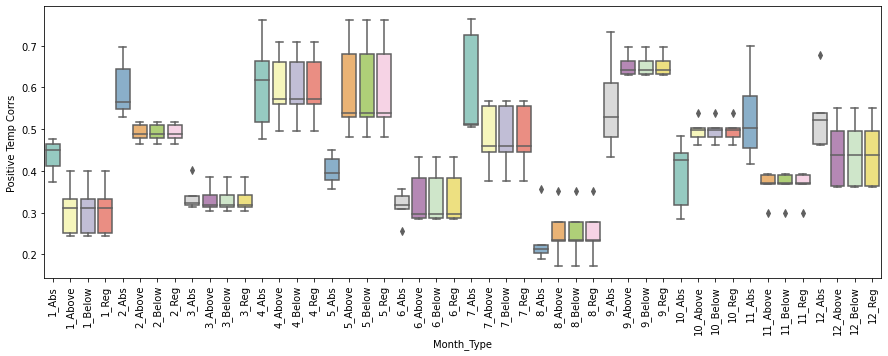

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Month_Type", y="Positive Temp Corrs",
                 data=corr_data, palette="Set3")
plt.xticks(rotation=90);

The best looking ones here are the candles for the month of September (9). This is because these candles show high correlations and are narrow.

## Negative Temperatures Correlations
These are the highest 5 negative correlations found between the correlation of temperature and all the variables in the merged data. This means that states with higher values on one of the variables means these states target COV go down as a result of the temperature variable.



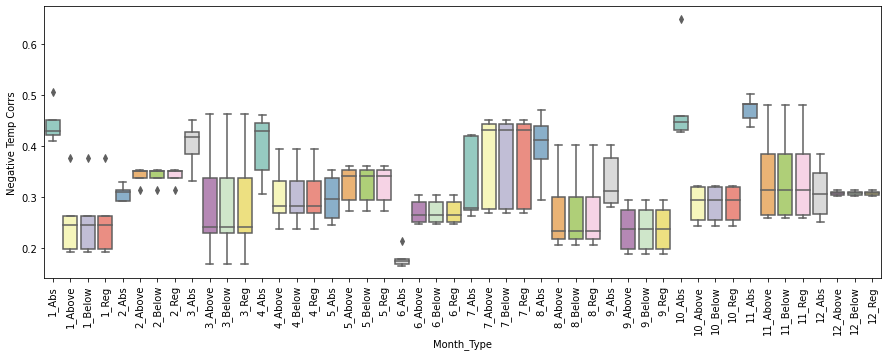

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Month_Type", y="Negative Temp Corrs",
                 data=corr_data, palette="Set3")
plt.xticks(rotation=90);

These negative correlations don't look quite as good, but out of all of them, the candles for the month of July have the highest median correlation.

## All Temperature Correlations
These are the highest 5 correlations found between the correlation of temperature and all the variables in the merged data.

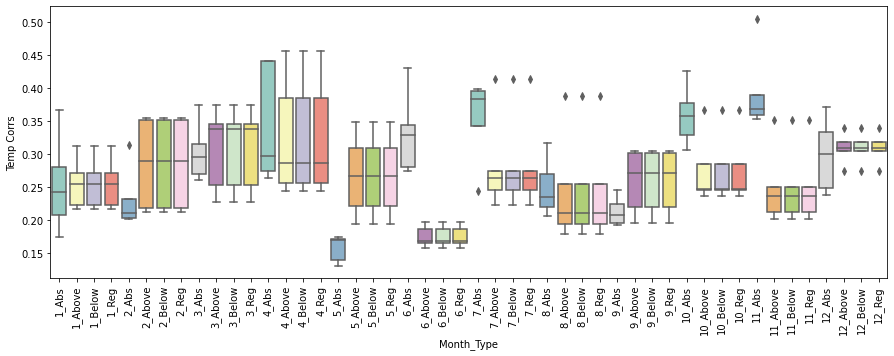

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Month_Type", y="Temp Corrs",
                 data=corr_data, palette="Set3")
plt.xticks(rotation=90);

Here, the best looking candles are for the month of December due to their narrow height and higher median correlation.

## Positive PDSI Correlations
These are the highest 5 positive correlations found between the correlation of pdsi and all the variables in the merged data. This means that states with higher values on one of the variables tend to have target COV go up as a result of the pdsi variable.

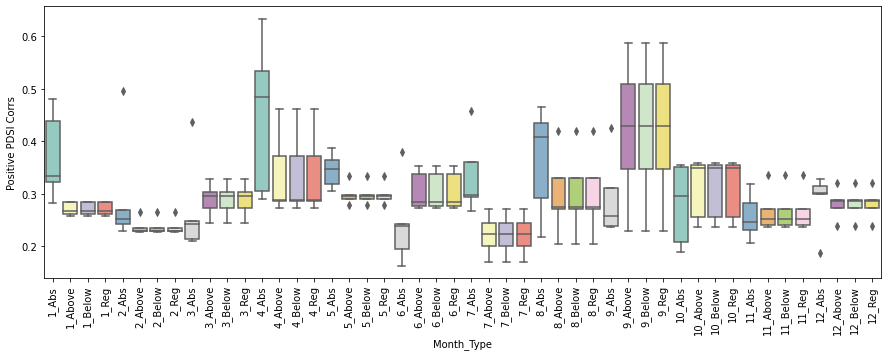

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Month_Type", y="Positive PDSI Corrs",
                 data=corr_data, palette="Set3")
plt.xticks(rotation=90);

Out of these candles, the ones for the month of September look the best.

## Negative PDSI Correlations
These are the highest 5 negative correlations found between the correlation of pdsi and all the variables in the merged data. This means that states with higher values on one of the variables tend to have target COV go down as a result of the pdsi variable.

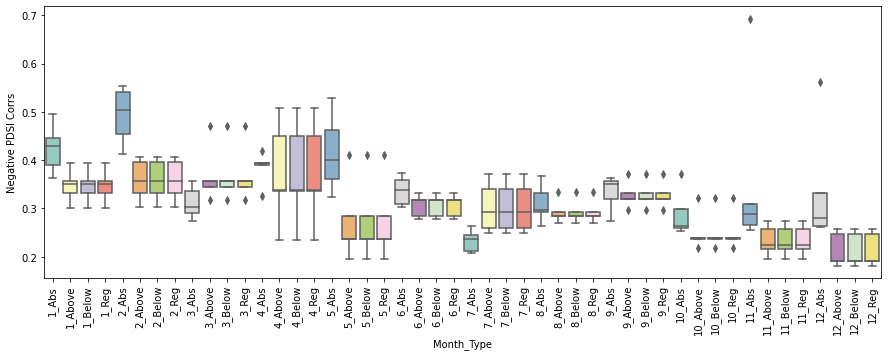

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Month_Type", y="Negative PDSI Corrs",
                 data=corr_data, palette="Set3")
plt.xticks(rotation=90);

This shows pretty nice correlations for February and the months that were below average as well as June. This implies that for these months, having more droughts makes the price volatility increase which makes sense, especially for June.

## All PDSI Correlations
These are the highest 5 correlations found between the correlation of pdsi and all the variables in the merged data.

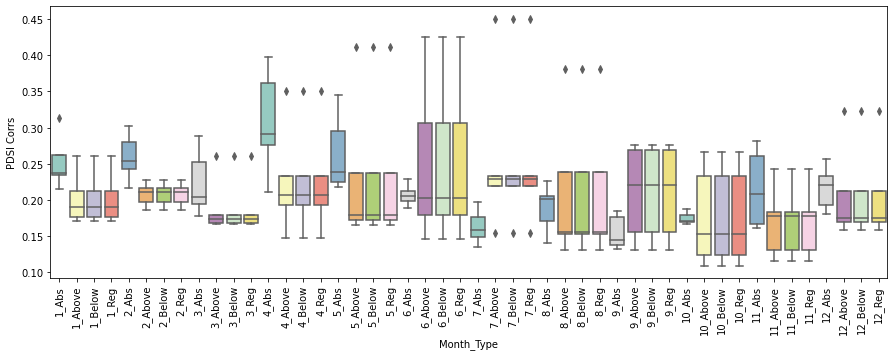

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="Month_Type", y="PDSI Corrs",
                 data=corr_data, palette="Set3")
plt.xticks(rotation=90);

Here the best options look like either february, march, or april for below.

# Find out which variables are correlated with the correlation of the weather and price volatility.

Positive Correlation Variables for Temperature

In [ ]:
corr_data.query('Month==7 and Type=="Abs"')[['Positive Temp Corrs Names','Positive Temp Corrs','Month','Type']]

,Positive Temp Corrs Names,Positive Temp Corrs,Month,Type
120,Percent Biomass,0.764722,7,Abs
121,Percent Batteries,0.724375,7,Abs
122,Percent Natural Gas,0.513116,7,Abs
123,y,0.509318,7,Abs
124,Percent Hydroelectric,0.503952,7,Abs


Negative Correlation Variables for Temperature

In [ ]:
corr_data.query('Month==10 and Type=="Abs"')[['Negative Temp Corrs Names','Negative Temp Corrs','Month','Type']]

,Negative Temp Corrs Names,Negative Temp Corrs,Month,Type
180,Percent Solar,0.650532,10,Abs
181,Percent Geothermal,0.459256,10,Abs
182,Percent Coal,0.447716,10,Abs
183,COM_percapita_mean_kWh_electricacc,0.431444,10,Abs
184,Agg_total_plant_count_x,0.373006,10,Abs


Positive Correlation Variables for PDSI

In [ ]:
corr_data.query('Month==4 and Type=="Abs"')[['Positive PDSI Corrs Names','Positive PDSI Corrs','Month','Type']]

,Positive PDSI Corrs Names,Positive PDSI Corrs,Month,Type
60,Percent Natural Gas,0.633679,4,Abs
61,COM_percapita_mean_kWh_statepop,0.532793,4,Abs
62,Percent Wind,0.484208,4,Abs
63,Percent Municipal Waste,0.304937,4,Abs
64,Percent Hydroelectric,0.289030,4,Abs


Negative Correlation Variables for PDSI

In [ ]:
corr_data.query('Month in [2,5] and Type=="Below"')[['Negative PDSI Corrs Names','Negative PDSI Corrs','Month','Type']]

,Negative PDSI Corrs Names,Negative PDSI Corrs,Month,Type
30,Percent Oil Gas,0.623184,2,Below
31,COM_percapita_mean_kWh_statepop,0.615026,2,Below
32,Percent Municipal Waste,0.534190,2,Below
33,x,0.460991,2,Below
34,Hot Summer Months,0.344973,2,Below
90,Percent Natural Gas,0.612804,5,Below
91,Percent Wind,0.561717,5,Below
92,Percent Hydroelectric,0.415709,5,Below
93,x,0.390248,5,Below
94,COM_percapita_mean_kWh_statepop,0.347306,5,Below


### Just for curiosity, let's look at the highest correlation variables

In [ ]:
corr_data_sorted_pos_temp = corr_data.sort_values(by='Positive Temp Corrs',ascending=False)
corr_data_sorted_neg_temp = corr_data.sort_values(by='Negative Temp Corrs',ascending=False)
corr_data_sorted_pos_pdsi = corr_data.sort_values(by='Positive PDSI Corrs',ascending=False)
corr_data_sorted_neg_pdsi = corr_data.sort_values(by='Negative PDSI Corrs',ascending=False)

Temperature and Positive Correlations

In [ ]:
corr_data_sorted_pos_temp.head(25)[['Positive Temp Corrs Names','Positive Temp Corrs','Month','Type']]

,Positive Temp Corrs Names,Positive Temp Corrs,Month,Type
150,Agg_total_plant_MWh_x,0.792632,8,Below
120,Percent Biomass,0.764722,7,Abs
60,Agg_total_plant_MWh_x,0.760823,4,Abs
95,Percent Batteries,0.760732,5,Reg
160,Percent Geothermal,0.731395,9,Abs
121,Percent Batteries,0.724375,7,Abs
125,Percent Biomass,0.720388,7,Above
75,Agg_total_plant_count_x,0.707927,4,Reg
126,Percent Batteries,0.702847,7,Above
205,Percent Biomass,0.702068,11,Above


Temperature and Negative Correlations

In [ ]:
corr_data_sorted_neg_temp.head(25)[['Negative Temp Corrs Names','Negative Temp Corrs','Month','Type']]

,Negative Temp Corrs Names,Negative Temp Corrs,Month,Type
180,Percent Solar,0.650532,10,Abs
0,Unnamed: 0,0.565422,1,Abs
185,Percent Solar,0.556709,10,Above
50,Percent Other,0.547687,3,Below
125,Dry Summer Months,0.544578,7,Above
51,Agg_total_plant_count_x,0.531707,3,Below
205,Percent Nuclear,0.527870,11,Above
206,Dry Summer Months,0.526042,11,Above
170,x,0.513598,9,Below
1,y,0.508592,1,Abs


### Look at the distribution of the correlations for the variables listed above as giving the best correlations from the candle charts.

In [ ]:
for i in range(12):
  print('\nMonth {}\n'.format(i+1))
  print('Absolute Value Corr: {}'.format(abs_temp_corr_dfs[i]['Correlation'].abs().mean()))

In [ ]:
abs_temp_corr_dfs[6]['Correlation'].abs().mean()

0.17116632266604595

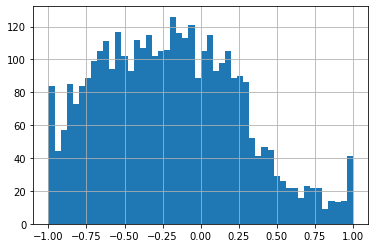

In [ ]:
below_temp_corr_dfs[7]['Correlation'].hist(bins=50)

In [ ]:
corr_data.query('Month==8 and Type=="Below"')[['Positive Temp Corrs Names','Positive Temp Corrs','Month','Type']]

,Positive Temp Corrs Names,Positive Temp Corrs,Month,Type
55,Percent Geothermal,0.385849,3,Reg
56,Percent Municipal Waste,0.319057,3,Reg
57,x,0.312829,3,Reg
58,COM_percapita_mean_kWh_statepop,0.303789,3,Reg
59,Percent Solar,0.294479,3,Reg


In [ ]:
corr_data.query('Month==11 and Type=="Reg"')[['Temp Corrs Names','Temp Corrs','Month','Type']]

,Temp Corrs Names,Temp Corrs,Month,Type
215,Unnamed: 0,0.364995,11,Reg
216,y,0.351696,11,Reg
217,Percent Hydroelectric,0.250097,11,Reg
218,Percent Biomass,0.236993,11,Reg
219,Percent Municipal Waste,0.212925,11,Reg


In [ ]:
july_below = below_temp_corr_dfs[7].groupby(by='State').mean().reset_index()[['State','Correlation']]

In [ ]:
july_below.head()

,State,Correlation
0,AK,-0.354680
1,AL,-0.111638
2,AR,0.106950
3,AZ,-0.261521
4,CA,0.013920


In [ ]:
july_belo = pd.merge(july_below,mean_by_state['Agg_total_plant_MWh_x'].reset_index(),on='State')

In [ ]:
july_belo.query('Correlation>0').corr()

,Correlation,Agg_total_plant_MWh_x
Correlation,1.000000,-0.792632
Agg_total_plant_MWh_x,-0.792632,1.000000


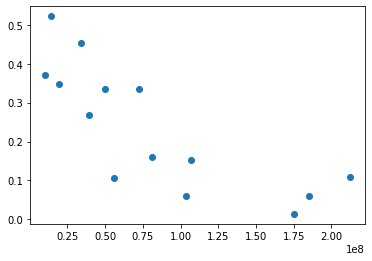

In [ ]:
plt.scatter(july_belo.query('Correlation>0')['Agg_total_plant_MWh_x'],july_belo.query('Correlation>0')['Correlation'])

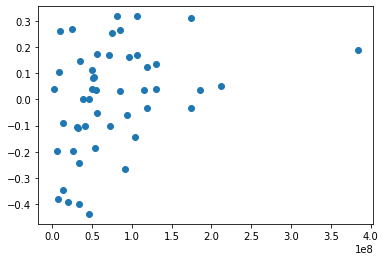

In [ ]:
reg = temp_corr_dfs[2].groupby(by='State').mean().reset_index()[['State','Correlation']]
regular = pd.merge(reg,mean_by_state['Agg_total_plant_MWh_x'].reset_index(),on='State')
plt.scatter(regular['Agg_total_plant_MWh_x'],regular['Correlation'])

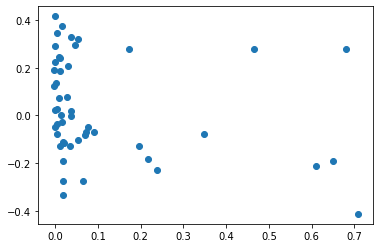

In [ ]:
reg = temp_corr_dfs[10].groupby(by='State').mean().reset_index()[['State','Correlation']]
regular = pd.merge(reg,mean_by_state['Percent Hydroelectric'].reset_index(),on='State')
plt.scatter(regular['Percent Hydroelectric'],regular['Correlation'])

In [ ]:
# this function takes in a dataframe of the correlations and then groups it by state, getting the mean correlation
def find_correlations(correlations_df, merged_data_state):
  corrs_by_state = correlations_df.groupby(by='State').mean()
  merged_data_all = pd.merge(merged_data_state,corrs_by_state,on='State')
  pos_corrs = merged_data_all.copy()[merged_data_all['Correlation']>=0]
  neg_corrs = merged_data_all.copy()[merged_data_all['Correlation']<0]
  top_pos_corrs = list(pos_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6])
  top_pos_corrs_names = list(pos_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6].index)
  top_neg_corrs = list(neg_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6])
  top_neg_corrs_names = list(neg_corrs.corr()['Correlation'].abs().sort_values(ascending=False)[1:6].index)
  return (top_pos_corrs, top_neg_corrs, top_pos_corrs_names, top_neg_corrs_names)

# Now I want to quickly look at how much correlation there is in target_COV and a states temperature/drought summary data

In [ ]:
merged_state_data = pd.merge(all_data_state,target_COV,on=['Year','State'],how='outer')

In [ ]:
merged_state_data.shape

(1049, 79)

In [ ]:
merged_state_data.corr()['target_COV'].sort_values()

Unnamed: 0                    -0.172024
y                             -0.163345
Temp Standard Deviations 10   -0.128133
Year                          -0.115905
Standardized Temp 2           -0.100135
                                 ...   
PDSI Averages 12               0.255087
Temp Averages 6                0.260677
Temp Averages 8                0.282480
Temp Averages 7                0.292944
target_COV                     1.000000
Name: target_COV, Length: 78, dtype: float64

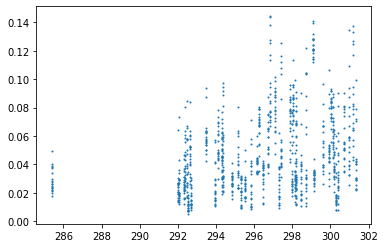

In [ ]:
plt.scatter(merged_state_data.query('target_COV<0.175')['Temp Averages 7'],merged_state_data.query('target_COV<0.175')['target_COV'],s=1)

# Train Linear Regression Model to Predict the correlations

In [ ]:
below_temp_corr_merged = pd.merge(below_pdsi_corr_dfs[8].copy().groupby(by='State').mean(),mean_by_state.reset_index(),on='State')

In [ ]:
below_temp_corr_merged.columns

Index(['State', 'Unnamed: 0', 'x', 'y', 'Correlation', 'Year',
       'COM_percapita_mean_kWh_electricacc',
       'RES_percapita_mean_kWh_electricacc', 'COM_percapita_mean_kWh_statepop',
       'RES_percapita_mean_kWh_statepop', 'Agg_total_plant_MWh_x',
       'Agg_total_plant_count_x', 'Percent Coal', 'Percent Wind',
       'Percent Batteries', 'Percent Solar', 'Percent Other',
       'Percent Oil Gas', 'Percent Nuclear', 'Percent Natural Gas',
       'Percent Municipal Waste', 'Percent Hydroelectric',
       'Percent Geothermal', 'Percent Biomass'],
      dtype='object')

In [ ]:
y = below_temp_corr_merged.copy()['Correlation']
x = below_temp_corr_merged.copy()
del x['Correlation']
del x['Year']
del x['Unnamed: 0']
del x['State']

In [ ]:
import statsmodels.api as sm

In [ ]:
# fit with everything
all_model = sm.OLS(y.astype(float), x.astype(float))
all_res = all_model.fit()

In [ ]:
all_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Correlation   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1.451
Date:                Tue, 23 Nov 2021   Prob (F-statistic):              0.176
Time:                        01:33:13   Log-Likelihood:                 11.320
No. Observations:                  50   AIC:                             17.36
Df Residuals:                      30   BIC:                             55.60
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
x                                     -0.0098      0.005     -1.925      0.064      -0.020       0.001
y                                      0.0137      0.012      1.165      0.253      -0.010       0.038
COM_percapita_mean_kWh_electricacc    -0.5606      3.230     -0.174      0.863      -7.157       6.036
RES_percapita_mean_kWh_electricacc     9.1178     17.592      0.518      0.608     -26.810      45.046
COM_percapita_mean_kWh_statepop       -0.4440      0.984     -0.451      0.655      -2.454       1.566
RES_percapita_mean_kWh_statepop       -0.3432      1.048     -0.327      0.746      -2.484       1.798
Agg_total_plant_MWh_x               8.854e-10   1.01e-09      0.876      0.388   -1.18e-09    2.95e-09
Agg_total_plant_count_x             -3.89e-05   4.19e-05     -0.929      0.360      -0.000    4.66e-05
Percent Coal                          -1.5853      0.817     -1.941      0.062      -3.253       0.083
Percent Wind                           0.6438      1.296      0.497      0.623      -2.004       3.292
Percent Batteries                   3325.4979   2854.544      1.165      0.253   -2504.259    9155.254
Percent Solar                          0.3318     12.214      0.027      0.979     -24.612      25.275
Percent Other                         25.7567     25.456      1.012      0.320     -26.231      77.745
Percent Oil Gas                       -1.1709      1.720     -0.681      0.501      -4.683       2.341
Percent Nuclear                       -0.9246      0.877     -1.055      0.300      -2.715       0.866
Percent Natural Gas                   -1.3023      0.897     -1.452      0.157      -3.135       0.530
Percent Municipal Waste                2.8621      7.590      0.377      0.709     -12.638      18.362
Percent Hydroelectric                 -2.2277      1.065     -2.092      0.045      -4.403      -0.053
Percent Geothermal                    -3.3426      6.717     -0.498      0.622     -17.061      10.375
Percent Biomass                        1.8612      1.830      1.017      0.317      -1.877       5.599
==============================================================================
Omnibus:                        1.710   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                1.080
Skew:                          -0.348   Prob(JB):                        0.583
Kurtosis:                       3.187   Cond. No.                     8.09e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.09e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""